In [23]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import tqdm
from astropy.io import fits
from firesong.Firesong import firesong_simulation
from multiprocessing import Pool
%matplotlib ipympl
from IPython.display import Latex,display
sys.path.append('../LHAASO_PSF/PSFConv/') 
import Plot
import PSF
import os

#------------------------参数设置----------------------------------

xsize = 640 #卷积前的图像尺寸，每像素对应尺度为 2*radius/xsize, 这个值应当设置得较小。
radius = 6.4 #图像半径， 可以修改至6.4,这样最后出来的图宽度为128
pixelwidth = radius*2/xsize
display(Latex('Pixel Width: $%.2f ^ \\circ/\\mathrm{pixel}$'%pixelwidth))
nfigure = 10 #生成多少张训练图像
ra_center = np.linspace(0,360,nfigure) #每张图像的中心坐标
dec_center = np.linspace(-90,90,nfigure)
NPROC = 5 # 线程数

psfradius = 1. #尽量不要修改，这里为了节约计算量，忽略了大于该半径的psf作用效果。（PSF卷积核半径）

binsize = 0.1  #单位是度，必须大于卷积前像素的尺度

NSIDE = 2048  #初始分辨率

#-------------------------程序主体----------------------------------

#检查背景文件是否存在
if os.path.exists('./gll_iem_v07.fits'):
    print('Good! File exists!')
else:
    print('File not found, start downloading.')
    os.system('wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/4fgl/gll_iem_v07.fits')
#galabkg = np.load('Fermi-LAT_pi0_map.npy')
#galabkg = hp.ud_grade(galabkg,NSIDE)
hdulist = fits.open('gll_iem_v07.fits')
data = hdulist[0].data[0,:,:]
galabkg = Plot.img2healpix(512,1024,data)

hp.mollview(np.log10(galabkg),rot = (180,0),title='Log10 Bkg')
hp.graticule(dpar = 10,dmer=10)

ModuleNotFoundError: No module named 'ipympl'

In [2]:
#！！！！！！！！！！！！！！！！！！！！！请不要随意修改如下部分！！！！！！！！！！！！！！！！！！！！！

ROI = []
ROI_BLUR = []

psfconv= PSF.fitpsf(0,plot=False)

idx = []
for i in range(nfigure):
    idx.append((ra_center[i],dec_center[i]))

def process(idx):
    ra_c,dec_c = idx
    #------真实坐标不重要---------
    npixedge = int(psfradius/pixelwidth)+1
    x = np.linspace(-radius+pixelwidth,radius,xsize)
    y = np.linspace(-radius+pixelwidth,radius,xsize)


    #含有边界，边界上psf无法很好卷积，会出现异常值。这里先包括额外的边界，然后卷积，然后再删掉边界
    x_edge = np.linspace(-radius-psfradius+pixelwidth,radius+psfradius,xsize+2*npixedge)
    y_edge = np.linspace(-radius-psfradius+pixelwidth,radius+psfradius,xsize+2*npixedge)

    #----------------按照中心坐标和半径选取天区-----------------------

    roi = Plot.selectreg_interp(galabkg,ra_c,dec_c,radius+psfradius,NSIDE,xsize=xsize+2*npixedge,plot = False)
    #print(roi.shape)
    #------------对图像逐一卷积，如果卷积前分辨率很高，耗时会很长。--------------------
    #使用了scipy.signal.convolve2d来卷积
    roi_blur = psfconv(roi,x_edge,y_edge,psfradius=psfradius)[npixedge:-npixedge,npixedge:-npixedge]
    roi = roi[npixedge:-npixedge,npixedge:-npixedge]
    #print(roi.shape)
    #print(npixedge)

    #-----------------重新分bin---------------------
    roi_rebin,xx,yy  = PSF.bindata(roi,x,y,binsize)
    blur_rebin,xx,yy = PSF.bindata(roi_blur,x,y,binsize)

    print('finish')
    return (roi_rebin,blur_rebin)
    #ROI.append(roi_rebin)
    #ROI_BLUR.append(blur_rebin)

with Pool(NPROC) as pool:
    res=pool.map(process,idx)
res = np.array(res)

finish
finish
finish
finish
finish
finish
finish
finish
finish
finish


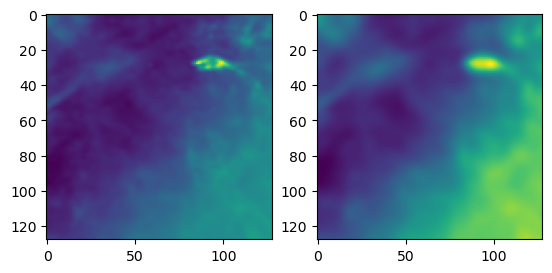

In [24]:
a = 8
fig,ax = plt.subplots(1,2)
ax[0].imshow(res[a][0])
ax[1].imshow(res[a][1])


In [ ]:
np.save('../SimulatedData/original.npy',res[:,0,:,:])
np.save('../SimulatedData/blurred.npy',res[:,1,:,:])